Author: Gilad Rubin
gilad.rubin@gmail.com

## Libraries Used

In [1]:
#import hvplot
#import hvplot.pandas

In [2]:
import pandas as pd
import numpy as np
import scipy
import sklearn

In [3]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split, StratifiedKFold 
from sklearn.model_selection import cross_val_score, cross_val_predict, ShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectFromModel, SelectPercentile, chi2, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import metrics

In [4]:
#If you don't want to use Dask - Comment it out and uncomment sklearn
#from sklearn.model_selection import GridSearchCV
#from dask_ml.model_selection import GridSearchCV

In [5]:
import optuna
from optuna.visualization import plot_intermediate_values

In [6]:
import xgboost as xgb
#import lightgbm as lgb

In [7]:
from catboost import CatBoost
from catboost import Pool

In [8]:
import cleanlab

In [9]:
SEED = 85

Fast - Lots Of Options. We want to try out as many
Explainable
Accurate
Stable
Easy interface

Scalable, Distributed
Smart sampling
"Minimal" Output
Easy to use

Different HPs need different sampling strategies
Conditional HPs

Preprocessing / Pipeline
Early Stopping
Pruning
Learning Rate Decay
CV

# Get Dataset

In [6]:
dataset = fetch_20newsgroups(data_home="news", subset='all', shuffle = False, remove=['headers', 'footers', 'quotes'])

In [7]:
len(dataset.data)

18846

In [8]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

## Add Word Count

In [9]:
word_count = [len(x.split()) for x in dataset.data]

In [10]:
df = pd.DataFrame({"text" : dataset.data,
                   "subclass_index" : dataset.target,
                   "word_count" : word_count})

# Word Count Filtering - Second Phase

In [11]:
df.sort_values("word_count", inplace=True)

In [12]:
df.head()

,text,subclass_index,word_count
4221,\n,7,0
8031,\n\n\n\n\n\n\n\n\n\n,7,0
15997,,9,0
850,,7,0
852,,11,0


In [13]:
df["word_count"].median()

83.0

In [14]:
len(df)

18846

In [15]:
df = df[df["word_count"] > 30]

In [16]:
len(df)

15387

# Add some useful columns for later use

### Subclass Columns

In [17]:
target_prefix = 'sci'

In [18]:
df["subclass_name"] = [dataset.target_names[class_num] for class_num in df["subclass_index"]]

In [19]:
df["binary_label"] = np.where(df["subclass_name"].str.startswith(target_prefix), 1, 0)

In [20]:
df["subclass_name_vs_other"] = np.where(df["binary_label"]==1, df["subclass_name"], "other")

In [21]:
#reorder columns
df = df[["text", "subclass_name", "binary_label", "subclass_name_vs_other", "word_count"]]

In [22]:
df.head()

,text,subclass_name,binary_label,subclass_name_vs_other,word_count
2637,"\n\n\n\nThat last was me, Steve Novak. I've s...",rec.sport.baseball,0,other,31
17711,\n\tThomas Jefferson is rolling over in his gr...,talk.politics.mideast,0,other,31
10054,"\n\nDo you, by any chance own an SHO or have a...",rec.autos,0,other,31
6519,Has anyone done a model of the 52 pin version ...,sci.electronics,1,sci.electronics,31
346,I have the following program on CD ROM forsale...,misc.forsale,0,other,31


In [23]:
df.to_pickle("newsgroup.pkl")

# Train-Test Split

In [24]:
df_train, df_test, y_train, y_test = train_test_split(df, df["binary_label"], 
                                                    test_size = 0.33, 
                                                    random_state = SEED, 
                                                    stratify = df["binary_label"])

In [25]:
#because Pandas....
df_train = df_train.copy()
df_test = df_test.copy()

In [26]:
sum(y_train)

2220

In [27]:
len(y_train)

10309

# Build Pipeline

In [28]:
pipeline = Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2), 
                                               min_df=5,
                                               use_idf=False, 
                                               smooth_idf=False,                                               
                                               strip_accents="unicode",
                                               encoding = "latin1",
                                               stop_words="english",
                                               sublinear_tf=True,
                                               norm="l2"))
                     #Remove Noisy Features with Importance==0 from RF
#                    ("rf_sel", SelectFromModel(RandomForestClassifier(n_estimators = 400,
#                                                                        min_samples_leaf = 2, 
#                                                                        class_weight = "balanced", 
#                                                                        random_state=SEED,
#                                                                        n_jobs=-1), threshold=1e-15))
                    ])

In [29]:
X_train = pipeline.fit_transform(df_train["text"], y_train)
X_test = pipeline.transform(df_test["text"])

In [11]:
from scipy.sparse import save_npz, load_npz

In [31]:
save_npz("X_train.npz", X_train)
pd.to_pickle(y_train, "y_train.pkl")

In [32]:
save_npz("X_test.npz", X_test)
pd.to_pickle(y_test, "y_test.pkl")

In [12]:
X_train = load_npz("./data/X_train.npz")
y_train = pd.read_pickle("./data/y_train.pkl")
X_test = load_npz("./data/X_test.npz")
y_test = pd.read_pickle("./data/y_test.pkl")

In [13]:
#https://github.com/Y-oHr-N/mllib/blob/master/mllib/model_selection.py

In [14]:
#TODO: add MLP 
#https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [15]:
from sklearn.base import ClassifierMixin

In [16]:
from sklearn.base import clone
from copy import deepcopy
from sklearn.utils import safe_indexing

In [17]:
class XGBClassifierLR(ClassifierMixin):
    def __init__(self, model_params=None, n_estimators=None, learning_rates=None):
        self.learning_rates = learning_rates
        self.model_params   = model_params
        self.n_estimators   = n_estimators
        
    def fit(self, X, y, sample_weight=None):
        dtrain = xgb.DMatrix(X, label=y)
        model  = xgb.train(self.model_params
                          ,dtrain
                          ,num_boost_round=self.n_estimators
                          ,learning_rates=self.learning_rates
                          )
        self.model = model
    
    def predict(self, X):
        test_dmatrix = xgb.DMatrix(X)
        return self.model.predict(test_dmatrix, output_margin=False)
    
    def predict_proba(self, X):
        test_dmatrix = xgb.DMatrix(X)
        return self.model.predict(test_dmatrix, output_margin=True)
    
    def get_params(self):
        return self.learning_rates

In [18]:
class RFClassifierOptuna(object):    
    def __init__(self, n_trees_per_iter=20, seed=42):
        self.random_state      = seed
        self.n_trees_per_iter  = n_trees_per_iter
        self.n_estimators      = 0
        self.best_n_estimators = 0
    
    def set_train(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
    def set_test(self, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
    
    def choose_and_set_params(self, trial, weights):
        scale_dict = {0:weights[0], 1:weights[1]}
        model_params = {'class_weight'      : scale_dict
                       ,'random_state'      : self.random_state
                       ,'criterion'         : trial.suggest_categorical('tree_criterion', ['gini', 'entropy'])
                       ,'bootstrap'         : trial.suggest_categorical('bootstrap', [False, True])
                       ,'max_depth'         : trial.suggest_int('max_depth', 2, 100)
                       ,'min_samples_leaf'  : trial.suggest_int('min_samples_leaf', 1, 20)
                       ,'max_features'      : 'auto'
                        ,#'max_features'      : trial.suggest_uniform('max_features', 0.1, 1.0) 
                       }
        
        self.model_params = model_params
    
    def train_one_iteration(self):
        if self.n_estimators==0:
            self.model = RandomForestClassifier(**self.model_params
                                                ,n_estimators=self.n_trees_per_iter
                                                ,n_jobs=1
                                                ,warm_start=True)
        
        self.model.fit(self.X_train, self.y_train)
        self.model.n_estimators += self.n_trees_per_iter
        self.n_estimators += self.n_trees_per_iter
            
    def score_test(self, scorer):
        preds = self.model.predict_proba(self.X_test)[:,1]
        return scorer(self.y_test, preds)
        
    def save_best(self):        
        self.best_n_estimators += self.n_trees_per_iter
        
    def create_model(self):
        self.model_params['n_estimators']=self.best_n_estimators
        self.model_params['n_jobs']=-1
        self.model_params['class_weight']="balanced"
        final_model = RandomForestClassifier(**self.model_params)
        return final_model

In [19]:
class LGBClassifierLR(ClassifierMixin):
    def __init__(self, model_params=None, n_estimators=None, learning_rates=None):
        self.model_params   = model_params
        self.n_estimators   = n_estimators
        self.learning_rates = learning_rates
        
    def fit(self, X, y, sample_weight=None):
        dtrain = lgb.Dataset(X, label=y)
        model  = lgb.train(self.model_params
                          ,dtrain
                          ,num_boost_round=self.n_estimators
                          ,learning_rates=self.learning_rates
                          )
        self.model = model
    
    def predict(self, X):
        return self.model.predict(X)
        #TODO Fix
    
    def predict_proba(self, X):
        return self.model.predict(X)
    
    def get_params(self):
        return self.learning_rates

In [20]:
class LGBClassifierOptuna(object):    
    def __init__(self, lr_decay=0.5, seed=42):
        self.random_state   = seed
        self.lr_decay       = lr_decay
        self.n_estimators   = 0
        self.learning_rates = []
    
    def set_train(self, X_train, y_train):
        self.ratio = sum(y_train==1) / len(y_train)
        self.dtrain  = lgb.Dataset(X_train,
                                   label=y_train, 
                                   free_raw_data=False,
                                  )
        
    def set_test(self, X_test, y_test):
        self.dtest = lgb.Dataset(X_test, 
                                 label=y_test, 
                                 free_raw_data=False, 
                                )
        self.X_test = X_test
        
    def choose_and_set_params(self, trial, weights):        
        pos_weight = weights[1]
        model_params = {'seed'               : self.random_state
                       ,'metric'             : 'auc'
                       ,'n_jobs'             : -1
                       ,'verbose'            : 0
                       ,'boost_from_average' : False
                       #,'max_bin'            : 255
                       ,'objective'          : trial.suggest_categorical('objective', ['xentropy']) #'binary'
                       ,'learning_rate'      : trial.suggest_loguniform('init_learning_rate', 1e-2, 1.0)
                       ,'tree_learner'       : 'feature'
                       ,'boosting_type'      : trial.suggest_categorical('boosting', ['gbdt', 'goss', 'dart'])
                       ,'scale_pos_weight'   : pos_weight #trial.suggest_uniform('scale_pos_weight', 1.0, 10.0)
                       ,'num_leaves'         : trial.suggest_int('num_leaves', 10, 100)
                       ,'min_child_weight'   : trial.suggest_loguniform('lgb_min_child_weight', 1e-3, 30.0)
                       ,'min_data_in_leaf'   : trial.suggest_int('min_data_in_leaf', 1, 30)
                       ,'subsample'          : trial.suggest_uniform('subsample', 0.5, 1.0)
                       ,'colsample_bytree'   : trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
                      }
        
        if model_params['boosting_type'] == 'dart':
            model_params['drop_rate'] = trial.suggest_loguniform('drop_rate', 1e-8, 1.0)
            model_params['skip_drop'] = trial.suggest_loguniform('skip_drop', 1e-8, 1.0)
        
        if model_params['boosting_type'] == 'goss':
            model_params['top_rate'] = trial.suggest_uniform('top_rate', 0.0, 1.0)
            model_params['other_rate'] = trial.suggest_uniform('other_rate', 0.0, 1.0 - model_params['top_rate'])
        
        if model_params['boosting_type'] == 'rf':
            model_params['bagging_freq'] = 2
        
        self.model_params = model_params
    
    def train_one_iteration(self):
        if self.n_estimators == 0:
            init_model = None
        else:
            init_model = self.best_model
            self.dtrain = self.dtrain.set_init_score(None)
            self.dtest = self.dtest.set_init_score(None)
        
        self.model = lgb.train(self.model_params
                              ,self.dtrain
                              ,init_model=init_model
                              ,num_boost_round=1
                              ,valid_sets=[self.dtest]
                              ,verbose_eval=False
                              )
        
    def score_test(self, scorer):
        preds = self.model.predict(self.X_test)
        return scorer(self.dtest.get_label(), preds)
    
    def lower_complexity(self):
        self.model_params['learning_rate'] *= self.lr_decay
        
    def save_best(self):
        self.best_model = self.model        
        self.learning_rates.append(self.model_params['learning_rate'])
        self.n_estimators += 1
        
    def create_model(self):
        final_model = LGBClassifierLR(self.model_params, self.n_estimators, self.learning_rates)
        return final_model

In [21]:
class SGDClassifierLR(ClassifierMixin):
    def __init__(self, model_params=None, n_estimators=None, learning_rates=None):
        self.model_params   = model_params
        self.n_estimators   = n_estimators
        self.learning_rates = learning_rates
        
    def fit(self, X, y, sample_weight=None):
        classes = np.unique(y)
        model = sklearn.linear_model.SGDClassifier(**self.model_params
                                                   ,max_iter=1
                                                   ,warm_start=True
                                                   ,verbose=0
                                                   ,early_stopping=False
                                                   ,n_jobs=-1
                                                   ,tol=1e-5
                                                   )
        for i in range(self.n_estimators):
            model.set_params(eta0 = self.learning_rates[i])
            model.partial_fit(X, y, classes)
        
        self.model = model
    
    def predict(self, X):
        return self.model.predict(X)
    
    def predict_proba(self, X):
        try:
            preds = self.model.predict_proba(X)
        except:
            preds = self.model.decision_function(X)
                    
        return preds
    
    def get_params(self):
        return self.learning_rates

In [22]:
class XGBClassifierOptuna(object):    
    def __init__(self, lr_decay=0.5, seed=42):
        self.random_state   = seed
        self.lr_decay       = lr_decay
        self.n_estimators   = 0
        self.learning_rates = []
    
    def set_train(self, X_train, y_train):
        self.dtrain = xgb.DMatrix(X_train, label=np.array(y_train))
        
    def set_test(self, X_test, y_test):
        self.dtest  = xgb.DMatrix(X_test, label=np.array(y_test))
    
    def choose_and_set_params(self, trial, weights):        
        pos_weight = weights[1]
        model_params = {'seed'             : self.random_state
                       ,'verbosity'        : 0
                       ,'nthread'          : -1
                       ,'scale_pos_weight' : pos_weight
                       ,'objective'        : 'binary:logistic'
                       ,'eta'              : trial.suggest_loguniform('init_eta', 1e-3, 1.0)
                       ,'booster'          : trial.suggest_categorical('booster', ['gblinear'])#, 'gbtree', 'dart'])
                       ,'lambda'           : trial.suggest_loguniform('lambda', 1e-10, 1.0)
                       ,'alpha'            : trial.suggest_loguniform('alpha', 1e-10, 1.0)
                      }

        if  model_params['booster'] in ['gbtree', 'dart']:
            tree_dict = {'max_depth'         : trial.suggest_int('max_depth', 2, 20)
                        ,'min_child_weight'  : trial.suggest_int('min_child_weight', 1, 20)
                        ,'gamma'             : trial.suggest_loguniform('gamma', 1e-10, 1.0)
                        ,'grow_policy'       : trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
                        ,'subsample'         : trial.suggest_uniform('subsample', 0.5, 1.0)
                        ,'colsample_bytree'  : trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
                        ,'colsample_bynode'  : trial.suggest_uniform('colsample_bynode', 0.1, 1.0)
                        ,'num_parallel_tree' : trial.suggest_int('num_parallel_tree', 1, 20)
                       }
            
            model_params.update(tree_dict)
        
        else: #gblinear
            model_params['feature_selector'] = trial.suggest_categorical('shotgun_feature_selector', ['cyclic', 'shuffle'])

        if  model_params['booster'] == 'dart':
            dart_dict = {'sample_type'    : trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
                        ,'normalize_type' : trial.suggest_categorical('normalize_type', ['tree', 'forest'])
                        ,'rate_drop'      : trial.suggest_loguniform('rate_drop', 1e-8, 1.0)
                        ,'skip_drop'      : trial.suggest_loguniform('skip_drop', 1e-8, 1.0)
                       }
            
            model_params.update(dart_dict)
        
        self.model_params = model_params
    
    def train_one_iteration(self):
        if self.n_estimators == 0:
            init_model = None
        else:
            init_model = self.best_model
            init_model.set_param({"eta" : self.model_params['eta']})
        
        self.model = xgb.train(self.model_params
                              ,self.dtrain
                              ,xgb_model=init_model
                              ,num_boost_round=1
                              ,learning_rates=[self.model_params['eta']]
                              )

    def score_test(self, scorer):
        preds = self.model.predict(self.dtest)
        return scorer(self.dtest.get_label(), preds)
    
    def lower_complexity(self):
        self.model_params['eta'] = self.model_params['eta'] * self.lr_decay
    
    def save_best(self):
        self.best_model = self.model.copy() 
        self.learning_rates.append(self.model_params['eta'])
        self.n_estimators += 1
        
    def create_model(self):
        final_model = XGBClassifierLR(self.model_params, self.n_estimators, self.learning_rates)
        return final_model

In [23]:
class SGDClassifierOptuna(object):    
    def __init__(self, lr_decay=0.5, seed=42):
        self.random_state   = seed
        self.lr_decay       = lr_decay
        self.n_estimators   = 0
        self.learning_rates = []
    
    def set_train(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.classes = np.unique(self.y_train)
        
    def set_test(self, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        
    def choose_and_set_params(self, trial, weights):        
        scale_dict = {0:weights[0], 1:weights[1]}
        losses = ['log', 'modified_huber', 'squared_hinge', 'perceptron', 'hinge']
        learning_rates = ['constant', 'optimal', 'invscaling'] #'adaptive'

        model_params = {'random_state'     : self.random_state
                       ,'loss'             : trial.suggest_categorical('loss', losses)
                       ,'penalty'          : trial.suggest_categorical('penalty', ['none', 'l1', 'l2', 'elasticnet'])
                       ,'alpha'            : trial.suggest_loguniform('alpha', 1e-8, 1.0)
                       ,'learning_rate'    : 'constant'
                       #,'learning_rate'    : trial.suggest_categorical('sgd_learning_rate', learning_rates)
                       ,'eta0'             : trial.suggest_loguniform('eta0', 1e-2, 1.0)
                       ,'class_weight'     : scale_dict
                      }
            
        if model_params['penalty'] == 'elasticnet':
            model_params['l1_ratio'] = trial.suggest_uniform('l1_ratio', 0, 1.0)
        
        if model_params['learning_rate'] == 'invscaling':
            model_params['power_t'] = trial.suggest_uniform('eta0', 0.2, 1.0)
        
        self.model_params = model_params
    
    def train_one_iteration(self):
        if self.n_estimators==0:
            self.model = sklearn.linear_model.SGDClassifier(**self.model_params
                                                           ,max_iter=1
                                                           ,warm_start=True
                                                           ,verbose=0
                                                           ,early_stopping=False
                                                           ,n_jobs=-1
                                                           ,tol=1e-5
                                                           )
        else:
            self.model = deepcopy(self.best_model)
            self.model.set_params(eta0 = self.model_params['eta0'])    
        
        self.model.partial_fit(self.X_train, self.y_train, self.classes)
    
    def score_test(self, scorer):
        if self.model_params["loss"] in ['log', 'modified_huber']:
            preds = self.model.predict_proba(self.X_test)[:,1]
        else:
            preds = self.model.decision_function(self.X_test)
            
        return scorer(self.y_test, preds)
    
    def lower_complexity(self):
        self.model_params['eta0'] *= self.lr_decay
        
    def save_best(self):
        self.best_model = deepcopy(self.model)
        self.learning_rates.append(self.model_params['eta0'])
        self.n_estimators += 1
        
    def create_model(self):
        final_model = SGDClassifierLR(self.model_params, self.n_estimators, self.learning_rates)
        return final_model

In [24]:
class Objective(object):
    def __init__(self
                 ,X
                 ,y
                 ,pipeline
                 ,pipe_params
                 ,estimator
                 ,tol = 1e-7
                 ,cv=5
                 ,groups=None
                 ,agg_func=np.mean
                 ,max_iter=1000
                 ,max_fails=10
                 ,scoring=sklearn.metrics.balanced_accuracy_score
                #,num_iter_check=5
                ):
        self.X           = X
        self.y           = y
        self.pipeline    = pipeline
        self.pipe_params = pipe_params
        self.estimator   = estimator
        self.tol         = tol
        self.cv          = cv
        self.agg_func    = agg_func
        self.groups      = groups
        self.max_iter    = max_iter
        self.max_fails   = max_fails
        self.scoring     = scoring


    def __call__(self, trial):
        if self.pipeline is not None:
            pipeline = clone(self.pipeline)
            pipe_params = self._get_params(trial)
            pipeline.set_params(**pipe_params)
        
        weights = sklearn.utils.class_weight.compute_class_weight("balanced", np.unique(self.y), self.y)
        estimator_list = []
        
        #create k folds and estimators
        for train, test in self.cv.split(self.X, self.y, groups=self.groups):
            X_train, y_train = safe_indexing(self.X, train), safe_indexing(self.y, train)
            X_test, y_test = safe_indexing(self.X, test), safe_indexing(self.y, test)

            if pipeline is not None:
                X_train = pipeline.fit_transform(X_train, y_train)
                X_test  = pipeline.transform(X_test)
        
            self.estimator.choose_and_set_params(trial, weights)
            estimator = deepcopy(self.estimator)
            
            estimator.set_train(X_train, y_train)
            estimator.set_test(X_test, y_test)
            
            estimator_list.append(estimator)
        
        best_score = 0.0
        for step in range(self.max_iter):
            scores = []
            for estimator in estimator_list:
                estimator.train_one_iteration()
                fold_score = estimator.score_test(self.scoring)
                scores.append(fold_score)
            
            intermediate_value = self.agg_func(scores)
            trial.report(intermediate_value, step)
            
            #print("intermediate result = ", intermediate_value)
            
            if trial.should_prune(step):
                raise optuna.structs.TrialPruned()
            
            if intermediate_value >= best_score + self.tol:
                best_score  = intermediate_value
                fail_count = 0
                for estimator in estimator_list:
                    estimator.save_best()
            else:
                fail_count += 1
                if (fail_count >= self.max_fails) or (not hasattr(estimator_list[0], 'lower_complexity')):
                    break
                
                #TODO: make this step only after k times
                for estimator in estimator_list:
                    estimator.lower_complexity()

        model = estimator.create_model()
        if pipeline is not None:
            pipeline.steps.append(['classifier', model])
        else:
            pipeline = Pipeline([("classifier", model)])
        
        print('Score: ' + str(round(best_score,5)))
            
        trial.set_user_attr('pipeline', pipeline)

        return best_score
    
    def _get_params(self, trial):
        param_dict = {name: trial._suggest(name, distribution) for name, 
                      distribution in self.pipe_params.items()}
        return param_dict

In [45]:
xgb_estimator = XGBClassifierOptuna(lr_decay=0.3, seed=SEED)
lgb_estimator = LGBClassifierOptuna(lr_decay=0.5, seed=SEED)
sgd_estimator = SGDClassifierOptuna(lr_decay=0.5, seed=SEED)
rf_estimator  = RFClassifierOptuna(n_trees_per_iter=10, seed=SEED)

In [46]:
pipe_params = {"sel__percentile" : optuna.distributions.IntUniformDistribution(1,100)}

In [47]:
pipeline = Pipeline([("sel", SelectPercentile(chi2))])

In [48]:
cv_folds=5

In [49]:
objective = Objective(X_train
                     ,y_train
                     ,pipeline
                     ,pipe_params
                     ,xgb_estimator
                     #,lgb_estimator
                     #,sgd_estimator
                     #,rf_estimator
                     ,cv=StratifiedKFold(n_splits=cv_folds, random_state=SEED)
                     ,scoring=sklearn.metrics.roc_auc_score
                     ,agg_func=np.nanmean
                     ,tol=1e-5
                     ,max_fails=10
                     )

In [50]:
optuna.logging.set_verbosity(optuna.logging.WARN)
pruner = optuna.pruners.SuccessiveHalvingPruner(min_resource=4,
                                                reduction_factor=4)
sampler = optuna.samplers.TPESampler(seed=SEED)

In [51]:
study = optuna.create_study(pruner=pruner
                            ,sampler=sampler
                            ,study_name="test"
                            ,load_if_exists=True
                            ,direction="maximize"
                           )

In [52]:
%%time
study.optimize(objective
               ,n_trials=10
               ,n_jobs=-1
              )

Score: 0.5
Score: 0.96608
Score: 0.96913
Wall time: 23.1 s


In [42]:
len(study.trials)

10

In [53]:
study.best_value

0.9717157582842733

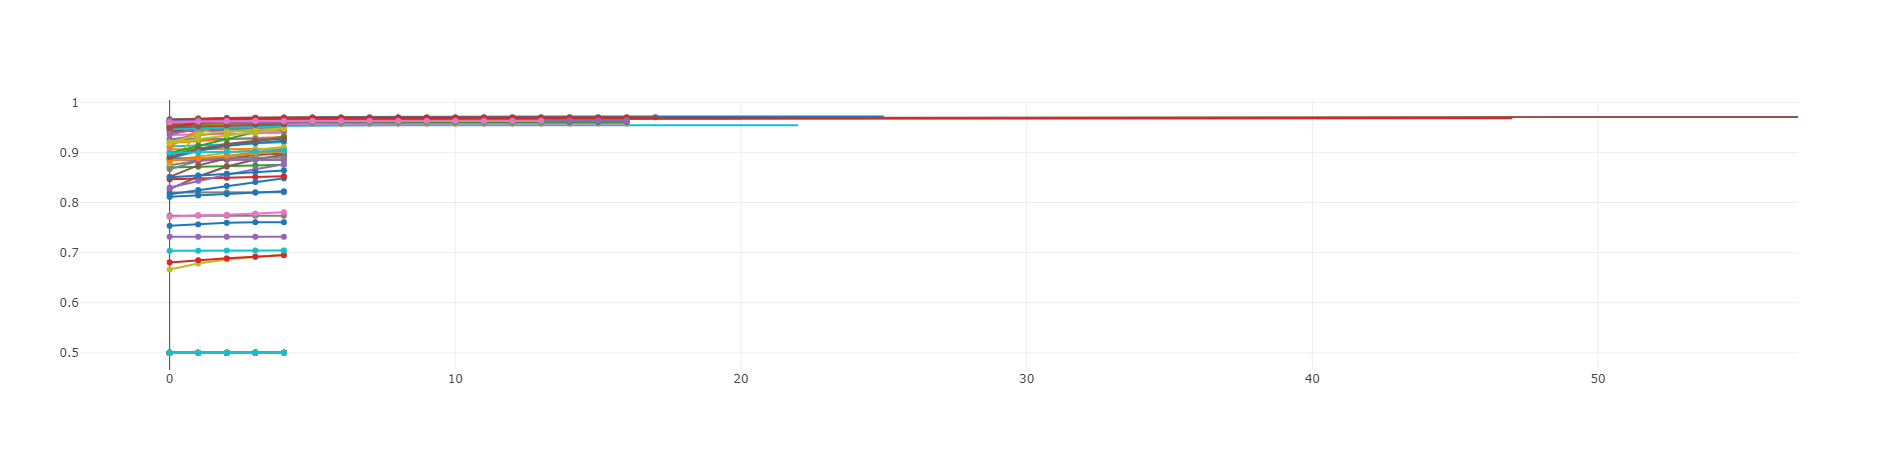

In [55]:
plot_intermediate_values(study)

In [64]:
study.best_trial.params

{'sel__percentile': 84,
 'init_eta': 0.032209923240669534,
 'booster': 'gblinear',
 'lambda': 1.9741756758315502e-10,
 'alpha': 5.724827930036961e-06,
 'shotgun_feature_selector': 'cyclic'}

In [ ]:
#Regular Training
#Grid/Random Search - Dependencies
#HyperOpt - API

In [ ]:
Optuna:
1. Define by run (Conditional HPs, Loops!)
2. Sampler (TPE + More to come)
3. Pruner - Async Successive Halving

In [ ]:
This Framework
4. CV
5. Sklearn + Pipeline
6. Learning Rate Decay
7. Iterative Training (Early Stopping)

In [65]:
final_pipeline = study.best_trial.user_attrs['pipeline']

In [66]:
final_pipeline = final_pipeline.fit(X_train, np.array(y_train))

In [67]:
final_pipeline.named_steps["classifier"].get_params()

[0.032209923240669534,
 0.032209923240669534,
 0.032209923240669534,
 0.032209923240669534,
 0.032209923240669534,
 0.032209923240669534,
 0.032209923240669534,
 0.032209923240669534,
 0.032209923240669534,
 0.032209923240669534,
 0.032209923240669534,
 0.032209923240669534,
 0.032209923240669534,
 0.032209923240669534,
 0.00966297697220086]

In [71]:
probs = final_pipeline.predict_proba(X_test)

In [69]:
#probs = probs[:,1]

In [70]:
sklearn.metrics.roc_auc_score(y_test, probs)

0.9713481439469027

In [88]:
trials_df = study.trials_dataframe()

In [89]:
pd.options.display.max_columns=700
trials_df.sort_values("value", ascending=False, inplace=True)

In [90]:
trials_df.head(10)

number                state     value             datetime_start  \
                                                                      
17     17  TrialState.COMPLETE  0.964063 2019-03-30 22:14:37.443517   
18     18  TrialState.COMPLETE  0.963573 2019-03-30 22:14:37.545518   
10     10  TrialState.COMPLETE  0.963408 2019-03-30 22:14:33.991517   
38     38  TrialState.COMPLETE  0.963399 2019-03-30 22:14:50.075518   
3       3  TrialState.COMPLETE  0.963254 2019-03-30 22:14:32.262524   
34     34  TrialState.COMPLETE  0.963222 2019-03-30 22:14:47.842518   
16     16  TrialState.COMPLETE  0.962887 2019-03-30 22:14:36.651520   
21     21    TrialState.PRUNED  0.962702 2019-03-30 22:14:38.658516   
11     11    TrialState.PRUNED  0.960387 2019-03-30 22:14:34.008518   
39     39    TrialState.PRUNED  0.960161 2019-03-30 22:14:50.202516   

            datetime_complete        params                                \
                                      alpha   average      eta0  l1_ratio   
17 2019-03-30 22:14:52.710515  1.525229e-03  8.041903  0.354110       NaN   
18 2019-03-30 22:14:42.715516  8.177901e-08  8.446077  0.214842       NaN   
10 2019-03-30 22:14:37.526519  1.028976e-06  9.332287  0.415689       NaN   
38 2019-03-30 22:14:58.784037  7.052542e-05  7.146406  0.475887       NaN   
3  2019-03-30 22:14:44.128517  1.045709e-06  1.137295  0.390234       NaN   
34 2019-03-30 22:14:54.425036  3.644950e-07  1.886711  0.060347       NaN   
16 2019-03-30 22:14:42.972518  3.046445e-07  2.335948  0.034991       NaN   
21 2019-03-30 22:14:48.201518  8.956594e-07  1.992968  0.031038  0.441804   
11 2019-03-30 22:14:38.647516  1.212608e-07  3.970100  0.056397  0.547794   
39 2019-03-30 22:14:56.037036  2.519911e-06  1.557593  0.546318       NaN   

                                                \
              loss     penalty sel__percentile   
17             log        none              61   
18           hinge        none              56   
10           hinge        none              60   
38           hinge          l2              36   
3              log          l2              88   
34   squared_hinge          l2              84   
16  modified_huber        none              70   
21  modified_huber  elasticnet              57   
11           hinge  elasticnet              42   
39             log          l1              13   

                                           user_attrs system_attrs  \
                                             pipeline      _number   
17  Pipeline(memory=None,\n     steps=[('sel', Sel...           17   
18  Pipeline(memory=None,\n     steps=[('sel', Sel...           18   
10  Pipeline(memory=None,\n     steps=[('sel', Sel...           10   
38  Pipeline(memory=None,\n     steps=[('sel', Sel...           38   
3   Pipeline(memory=None,\n     steps=[('sel', Sel...            3   
34  Pipeline(memory=None,\n     steps=[('sel', Sel...           34   
16  Pipeline(memory=None,\n     steps=[('sel', Sel...           16   
21                                                NaN           21   
11                                                NaN           11   
39                                                NaN           39   

                                                                        \
   completed_rung_0 completed_rung_1 completed_rung_2 completed_rung_3   
17         0.956767         0.960096         0.962521         0.963792   
18         0.960746         0.963054         0.963493              NaN   
10         0.962552         0.963373              NaN              NaN   
38         0.962060         0.963071         0.963350              NaN   
3          0.957600         0.960505         0.962417         0.963191   
34         0.960767         0.962733         0.963163              NaN   
16         0.957414         0.960862         0.962731              NaN   
21         0.956687         0.960487         0.962786         0.962702   
11         0.950080         0.955902       

In [493]:
top_k = 10

In [494]:
completed_indices = [index for index, x in enumerate(trials_df['state']) if 'COMPLETE' in str(x)]
pipelines = trials_df.iloc[completed_indices].head(top_k)['user_attrs'].values

In [495]:
#pipeline = pipelines[0][0]

In [258]:
test_probs = model.predict(dtest)

In [259]:
metrics.roc_auc_score(y_test, test_probs)

0.9765134578533512

In [936]:
class Objective(object):
    def __init__(self, pipeline, model_list):
        self.pipeline = pipeline
        self.model_list = model_list
        
    def __call__(self, trial):
        #use changing parameters (like tree depth) for xgboost and lightgbm
        #Ensembles: http://ml-ensemble.com/info/
        #remove test set and work with cv(?)
        #add tree limit as output for tree ensembles
        #add ensemble on top of best k models
        #add catboost
        #fix RF and Dart with lightgbm
        #convert learning rate decay to list for retraining

        model = trial.suggest_categorical('model', self.model_list)
        
        percentile = int(trial.suggest_int('percentile', 10, 100))
        selection = SelectPercentile(percentile=percentile, score_func=chi2)
        selection = selection.fit(X_train, y_train)
        X_train_t = selection.transform(X_train)
        X_test_t = selection.transform(X_test)
        
        weights = sklearn.utils.class_weight.compute_class_weight("balanced", np.unique(y_train), y_train)
        scale_dict = {0:weights[0], 1:weights[1]}

        max_boost_rounds = 200
        
        if model=='catboost':
            dtrain = Pool(pd.DataFrame(X_train_t.todense()), y_train) #cat_features=categorical_features_indices)
            dtest = Pool(pd.DataFrame(X_test_t.todense()), y_test) #cat_features=categorical_features_indices)

            params = {
                'loss_function'        : 'Logloss', 
                'eval_metric'          : 'AUC',
                'thread_count'         : 8,
                'random_seed'          : SEED,
                'boosting_type'        : "Plain",
                'boostrap_type'        : 'Bernoulli',
                'scale_pos_weight'     : trial.suggest_uniform('scale_pos_weight', 1.0, 10.0),
                'colsample_bylevel'    : trial.suggest_uniform('colsample_bylevel', 0.1, 1.0),
                'iterations'           : trial.suggest_int('iterations', 50, 100),
                'depth'                : trial.suggest_int('depth', 4, 10),                                       
                'learning_rate'        : trial.suggest_loguniform('learning_rate', 1e-3, 0.3),               
                'random_strength'      : trial.suggest_int('random_strength', 1, 20),                       
                'bagging_temperature'  : trial.suggest_uniform('bagging_temperature', 0.1, 1.0), 
                #'l2_leaf_reg'          : trial.suggest_loguniform('l2_leaf_reg', 0, np.log(10))
            }
            

            params['border_count'] = 128
            params['ctr_border_count'] = 16
            #params['leaf_estimation_method'] = 'Newton'
            #params['gradient_iterations'] = 10,
            params['od_type'] = 'Iter'
            params['od_wait'] = 5
            
            cat = CatBoost(params)
            cat.fit(dtrain, eval_set=dtest, use_best_model=False, verbose=False, 
                    early_stopping_rounds=5)
            
            auc = cat.get_best_score()['validation_0']['AUC']
            print("CatBoost score: " + str(round(auc, 5)))
            return auc
        
        if model=='xgboost':
            param = {'objective'        : 'binary:logistic',
                     'eval_metric'      : 'auc',
                     'seed'             : SEED,
                     'booster'          : trial.suggest_categorical('booster', ['gblinear']), #'gbtree', 'dart']),
                     'verbosity'        : 0,
                     'nthread'          : -1,
                     'lambda'           : trial.suggest_loguniform('lambda', 1e-10, 1.0),
                     'alpha'            : trial.suggest_loguniform('alpha', 1e-10, 1.0)
                     }

            if param['booster'] in ['gbtree', 'dart']:
                param['max_depth']         = trial.suggest_int('max_depth', 2, 20)
                param['min_child_weight']  = trial.suggest_int('min_child_weight', 1, 20)
                param['gamma']             = trial.suggest_loguniform('gamma', 1e-8, 1.0)
                param['grow_policy']       = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
                param['subsample']         = trial.suggest_uniform('subsample', 0.5, 1.0)
                param['colsample_bytree']  = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
                param['colsample_bynode']  = trial.suggest_uniform('colsample_bynode', 0.1, 1.0)
                param['num_parallel_tree'] = trial.suggest_int('num_parallel_tree', 1, 20)
            else: #gblinear
                param['feature_selector'] = trial.suggest_categorical('shotgun_feature_selector', ['cyclic', 'shuffle'])

            if param['booster'] == 'dart':
                param['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
                param['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
                param['rate_drop'] = trial.suggest_loguniform('rate_drop', 1e-8, 1.0)
                param['skip_drop'] = trial.suggest_loguniform('skip_drop', 1e-8, 1.0)
            
            #param['scale_pos_weight']  = trial.suggest_uniform('scale_pos_weight', 1.0, 30.0)
            param['scale_pos_weight']  = weights[1]
            dtrain = xgb.DMatrix(X_train_t, label=y_train)
            dtest  = xgb.DMatrix(X_test_t, label=y_test)
            
            pruning_callback = optuna.integration.XGBoostPruningCallback(trial, observation_key='eval-auc')
            
            #https://www.kaggle.com/ashhafez/xgb-learning-rate-eta-decay
            
            param['eta'] = trial.suggest_loguniform('init_eta', 1e-3, 1.0)
            min_eta   = param['eta'] * 1e-6
            eta_decay = 0.5
            max_fails = 5
    
            best_rounds         = 0
            pvalid              = None
            model               = None
            best_train_score    = None
            best_valid_score    = None
            fail_count          = 0
            best_rounds         = 0
            best_model          = None
            learning_rates      = []
            
            while param['eta'] >= min_eta:

                model        = xgb.train(param, 
                                         dtrain, 
                                         maximize=True, 
                                         evals=[(dtest, 'eval')], 
                                         num_boost_round=max_boost_rounds, 
                                         early_stopping_rounds=1,
                                         verbose_eval=False,
                                         callbacks=[pruning_callback]
                                        )
                
                rounds           = model.best_ntree_limit
                valid_score      = model.best_score
                
                if (best_valid_score is None) or (valid_score < best_valid_score):
                    fail_count = 0
                    best_valid_score = valid_score
                    best_rounds      = rounds
                    best_model       = model
                    
                    if param['booster'] == "gblinear":
                        ntree_limit = 0
                    else:
                        ntree_limit = rounds
                        
                    ptrain           = best_model.predict(dtrain, ntree_limit=ntree_limit, output_margin=True)
                    ptest            = best_model.predict(dtest, ntree_limit=ntree_limit, output_margin=True)
                    
                    dtrain.set_base_margin(ptrain)
                    dtest.set_base_margin(ptest)
                    
                    learning_rates  = learning_rates + ([param['eta']] * rounds)
                    
                else:
                    fail_count += 1
                    if fail_count >= max_fails:
                        break
                
                param["eta"]  = eta_decay * param["eta"]
            
            print('XGBoost score: ' + str(round(best_valid_score,5)))
            
            trial.set_user_attr('pipeline', (selection, param, learning_rates))
            
            return best_valid_score

        if model=='lightgbm':
            param = {'metric'             : 'auc',
                     'n_jobs'             : -1,
                     'seed'               : SEED,
                     'verbose'            : 0,
                     'boost_from_average' : False,
                     'objective'          : trial.suggest_categorical('objective', ['binary', 'xentropy']),
                     'boosting_type'      : trial.suggest_categorical('boosting', ['gbdt', 'goss']), #, 'rf' 'dart',
                     'scale_pos_weight'   : trial.suggest_uniform('scale_pos_weight', 1.0, 10.0),
                     'num_leaves'         : trial.suggest_int('num_leaves', 10, 100),
                     'min_child_weight'   : trial.suggest_loguniform('lgb_min_child_weight', 1e-3, 30.0),
                     'min_data_in_leaf'   : trial.suggest_int('min_data_in_leaf', 1, 30),
                     'subsample'          : trial.suggest_uniform('subsample', 0.5, 1.0),
                     'colsample_bytree'   : trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
                     }

            if param['boosting_type'] == 'dart':
                param['drop_rate'] = trial.suggest_loguniform('drop_rate', 1e-8, 1.0)
                param['skip_drop'] = trial.suggest_loguniform('skip_drop', 1e-8, 1.0)
            if param['boosting_type'] == 'goss':
                param['top_rate'] = trial.suggest_uniform('top_rate', 0.0, 1.0)
                param['other_rate'] = trial.suggest_uniform('other_rate', 0.0, 1.0 - param['top_rate'])
            if param['boosting_type'] == 'rf':
                param['bagging_freq'] = 2
                
            dtrain = lgb.Dataset(X_train_t, label=y_train)
            dtest = lgb.Dataset(X_test_t, label=y_test)

            pruning_callback = optuna.integration.LightGBMPruningCallback(trial, metric='auc')
            
            param['learning_rate'] = trial.suggest_loguniform('init_eta', 1e-2, 1.0)
            min_eta = param['learning_rate'] * 1e-6
            eta_decay = 0.5
            max_fails = 5
    
            best_rounds         = 0
            model               = None
            best_valid_score    = None
            fail_count          = 0
            best_rounds         = 0
            best_model          = None
            best_ptrain         = np.zeros(len(y_train))
            best_ptest          = np.zeros(len(y_test))
            learning_rates      = []
            
            while param['learning_rate'] >= min_eta:
                
                model        = lgb.train(param,
                                         dtrain,
                                         num_boost_round=max_boost_rounds,
                                         early_stopping_rounds=2,
                                         valid_sets=[dtest],
                                         verbose_eval=False,
                                         callbacks=[pruning_callback]
                                        )
                
                rounds          = model.best_iteration + 1

                valid_score     = list(model.best_score.values())[0]['auc']
                
                if best_valid_score is None or valid_score < best_valid_score:
                    fail_count = 0
                    best_valid_score = valid_score
                    best_rounds      = rounds
                    best_model       = model
                    
                    ptrain      = best_model.predict(X_train_t, num_iteration=rounds, raw_score=True)
                    ptest       = best_model.predict(X_test_t, num_iteration=rounds, raw_score=True)
                    
                    best_ptrain += ptrain
                    best_ptest  += ptest
                    
                    dtrain = lgb.Dataset(X_train_t, init_score=best_ptrain, label=y_train)
                    dtest = lgb.Dataset(X_test_t, init_score=best_ptest, label=y_test)
                    
                    learning_rates  = learning_rates + ([param['learning_rate']] * rounds)
                    
                else:
                    fail_count += 1
                    if fail_count >= max_fails:
                        break
                
                param['learning_rate']  = eta_decay * param['learning_rate']
            
            print('LightGBM score: ' + str(round(best_valid_score, 5)))
            return best_valid_score

        if model=="SGD":
            losses = ['log', 'modified_huber', 'squared_hinge', 'perceptron', 'hinge']
            learning_rates = ['constant', 'optimal', 'invscaling'] #'adaptive'

            param = {'average'          : True,
                     'loss'             : trial.suggest_categorical('loss', losses),
                     'learning_rate'    : trial.suggest_categorical('sgd_learning_rate', learning_rates),
                     'class_weight'     : trial.suggest_categorical('class_weight', [None, scale_dict]),
                     'penalty'          : trial.suggest_categorical('penalty', ['none', 'l1', 'l2', 'elasticnet']),
                     'fit_intercept'    : trial.suggest_categorical('fit_intercept', [False, True]),
                     'alpha'            : trial.suggest_loguniform('alpha', 1e-8, 1.0),
                     'eta0'             : trial.suggest_loguniform('eta0', 0.01, 1.0)
                    }

            if param["penalty"] == "elasticnet":
                param["l1_ratio"] = trial.suggest_uniform('l1_ratio', 0.1, 1.0)

            model = sklearn.linear_model.SGDClassifier(**param, verbose=0, 
                                                       random_state=SEED,
                                                       early_stopping=False, 
                                                       #n_iter_no_change=5, 
                                                       #validation_fraction=0,
                                                       #tol=1e-5,
                                                       n_jobs=-1,
                                                       #max_iter=max_boost_rounds
                                                      )
            n_iter_no_change=5
            tol = 1e-5
            counter=0
            max_value=0
            
            for step in range(0, max_boost_rounds):
                classes = np.unique(y_train)
                model.partial_fit(X_train_t, y_train, classes)
                if param["loss"] in ['log', 'modified_huber']:
                    preds = model.predict_proba(X_test_t)[:,1]
                else:
                    preds = model.decision_function(X_test_t)

                intermediate_value = sklearn.metrics.roc_auc_score(y_test, preds)

                trial.report(intermediate_value, step)
                if trial.should_prune(step):
                    raise optuna.structs.TrialPruned()

                if (counter%n_iter_no_change==0) & (intermediate_value-tol <= max_value):
                    break

                if intermediate_value > max_value:
                    max_value = intermediate_value
            
            print('SGD score: ' + str(round(max_value,5)))
            return max_value
        
        if model == "rf":
            n_features = X_train_t.shape[1]
            
            param = {'class_weight'      : scale_dict,
                     'random_state'      : SEED,
                     'criterion'         : trial.suggest_categorical('tree_criterion', ['gini', 'entropy']),
                     'bootstrap'         : trial.suggest_categorical('bootstrap', [False, True]),
                     'max_depth'         : trial.suggest_int('max_depth', 2, 100),
                     'min_samples_leaf'  : trial.suggest_int('min_samples_leaf', 1, 20),
                     #'max_features'      : trial.suggest_uniform('max_features', 0.1, 1.0) 
                     'max_features'      : 'auto' 
                    }
            
            n_iter_no_change=5
            tol = 1e-9
            counter=0
            max_value=0
            
            n_trees = 20
            
            growing_rf = RandomForestClassifier(**param
                                                ,n_estimators=n_trees
                                                ,n_jobs=1
                                                ,warm_start=True)
            for step in range(max_boost_rounds):
                growing_rf.fit(X_train_t, y_train)
                growing_rf.n_estimators += n_trees
                
                probs = growing_rf.predict_proba(X_test_t)[:,1]
                intermediate_value = sklearn.metrics.roc_auc_score(y_test, probs)

                trial.report(intermediate_value, step)
                if trial.should_prune(step):
                    raise optuna.structs.TrialPruned()

                if (counter%n_iter_no_change==0) & (intermediate_value-tol <= max_value):
                    break

                if intermediate_value > max_value:
                    max_value = intermediate_value
            
            print('Random Forest score: ' + str(round(max_value,5)))
            return max_value

        return 0

In [937]:
optuna.logging.set_verbosity(optuna.logging.WARN)
pruner = optuna.pruners.SuccessiveHalvingPruner(min_resource=6,
                                                reduction_factor=2)
sampler = optuna.samplers.TPESampler(seed=SEED)
#sampler = optuna.samplers.RandomSampler(seed=SEED)

In [938]:
model_list = ['lightgbm']
objective = Objective(pipeline, model_list)
study = optuna.create_study(pruner=pruner
                            ,sampler=sampler
                            ,direction="maximize"
                           )

In [939]:
%%time
study.optimize(objective
               ,n_trials=10
               ,n_jobs=-1
              )

LightGBM score: 0.90614
LightGBM score: 0.94576
LightGBM score: 0.95415
LightGBM score: 0.95773
LightGBM score: 0.94753
Wall time: 27.8 s


In [940]:
study.best_value

0.9577299141722282

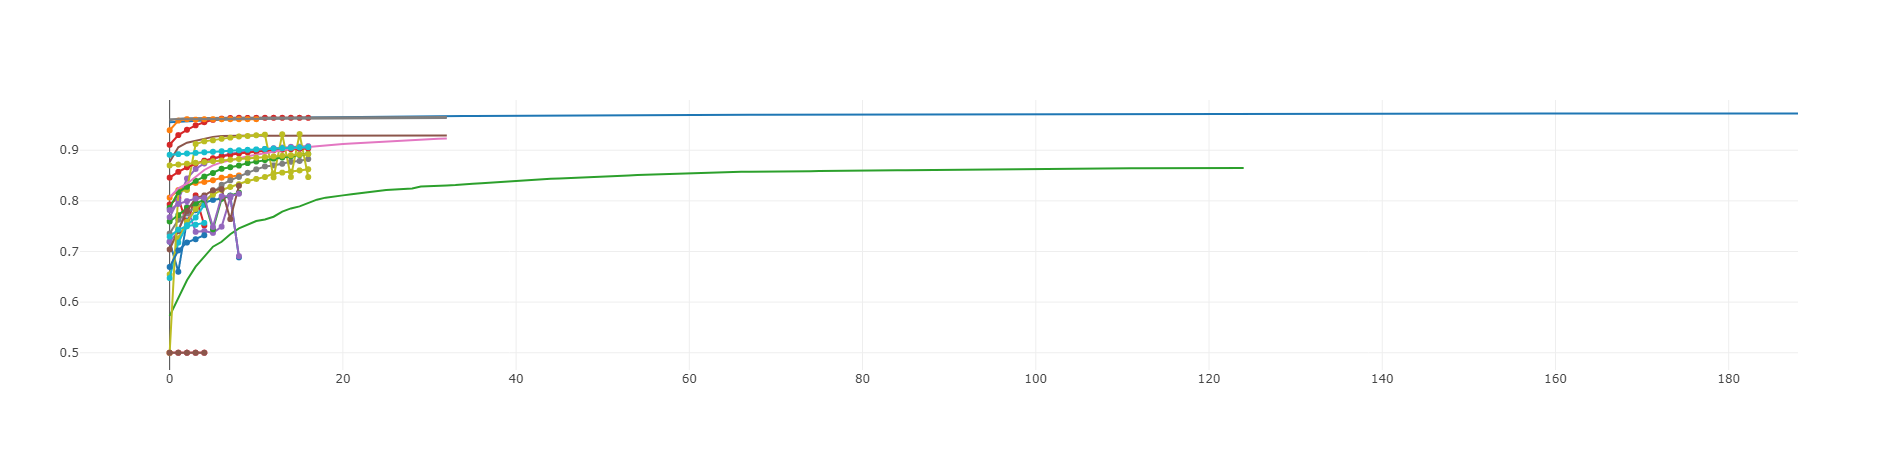

In [62]:
plot_intermediate_values(study)

In [942]:
study.best_trial.params

{'model': 'lightgbm',
 'percentile': 32,
 'objective': 'binary',
 'boosting': 'gbdt',
 'scale_pos_weight': 6.14235762135034,
 'num_leaves': 86,
 'lgb_min_child_weight': 0.0012069973389603336,
 'min_data_in_leaf': 3,
 'subsample': 0.6635286520315073,
 'colsample_bytree': 0.1507614752543441,
 'init_eta': 0.15759061752483355}

In [943]:
trials_df = study.trials_dataframe()
trials_df['intermediate_values'].max(axis=1).max()

0.9577299141722282

In [ ]:
pd.options.display.max_columns=700
trials_df.sort_values("value", ascending=False, inplace=True)

In [ ]:
trials_df.head(10)

In [251]:
top_k = 10

In [252]:
completed_indices = [index for index, x in enumerate(trials_df['state']) if 'COMPLETE' in str(x)]
pipelines = trials_df.iloc[completed_indices].head(top_k)['user_attrs'].values

In [253]:
pipeline = pipelines[0][0]

In [254]:
pipeline = study.best_trial.user_attrs['pipeline']

In [255]:
transformer = pipeline[0]
params = pipeline[1]
learning_rates = pipeline[2]

In [256]:
dtrain = xgb.DMatrix(transformer.transform(X_train), y_train)
dtest = xgb.DMatrix(transformer.transform(X_test))

In [257]:
model = xgb.train(params, dtrain, num_boost_round=len(learning_rates), learning_rates=learning_rates)

In [258]:
test_probs = model.predict(dtest)

In [259]:
metrics.roc_auc_score(y_test, test_probs)

0.9765134578533512

In [86]:
folds = 5
kf = StratifiedKFold(n_splits=folds
                     ,random_state=SEED)

In [87]:
ypred = np.zeros(len(y_train))
i=0
for train_ind,test_ind in kf.split(X_train, y_train):
    print('Fold', i+1, 'out of',folds)
    xtrain, ytrain = X_train[train_ind,:], y_train.values[train_ind]
    xtest,ytest = X_train[test_ind,:], y_train.values[test_ind]
    dtrain = xgb.DMatrix(transformer.transform(xtrain), ytrain)
    dtest = xgb.DMatrix(transformer.transform(xtest))
    model = xgb.train(params, dtrain, num_boost_round=len(learning_rates), learning_rates=learning_rates)
    #model.train(xtrain, ytrain)
    ypred[test_ind]=model.predict(dtest)
    i+=1

Fold 1 out of 5
Fold 2 out of 5
Fold 3 out of 5
Fold 4 out of 5
Fold 5 out of 5


In [88]:
from scipy.sparse import csr_matrix, hstack

In [89]:
X_train = hstack([transformer.transform(X_train), csr_matrix(ypred).T])

In [90]:
X_test = hstack([transformer.transform(X_test), csr_matrix(test_probs).T])

In [35]:
self.space = {
        #'boosting': hp.choice('boosting', ['gbdt', 'rf', 'dart', 'goss']),
        'learning_rate': hp.loguniform('learning_rate', -7, 0),
        'num_leaves': hp.qloguniform('num_leaves', 0, 7, 1),
        'max_depth': hp.choice('max_depth', [-1, hp.qloguniform('max_depth_positive', 0, 4, 1)]),
        'min_data_in_leaf': hp.qloguniform('min_data_in_leaf', 0, 6, 1),
        'min_sum_hessian_in_leaf': hp.loguniform('min_sum_hessian_in_leaf', -16, 5),
        'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1),
        'bagging_freq': hp.choice('bagging_freq', [0, hp.qloguniform('bagging_freq_positive', 0, 4, 1)]),
        'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),

        # tune?
        'max_delta_step': hp.choice('max_delta_step', [0.0, hp.loguniform('max_delta_step_positive', -7, 4)]),
        'lambda_l1': hp.choice('lambda_l1', [0, hp.loguniform('lambda_l1_positive', -16, 2)]),
        'lambda_l2': hp.choice('lambda_l2', [0, hp.loguniform('lambda_l2_positive', -16, 2)]),
        'min_gain_to_split': hp.choice('min_gain_to_split', [0.0, hp.loguniform('min_gain_to_split_positive', -16, -1)]),

        'min_data_per_group': hp.qloguniform('min_data_per_group', 0, 6, 1),
        'max_cat_threshold': hp.quniform('max_cat_threshold', 2, 128, 1),
        'cat_l2': hp.loguniform('cat_l2', 0, 3),
        'cat_smooth': hp.loguniform('cat_smooth', 0, 3),
        'max_cat_to_onehot': hp.qloguniform('max_cat_to_onehot', 0, 5, 1),
    }

    self.default_params = {
        'learning_rate': 0.1,
        'num_leaves': 127,
        'max_depth': -1,
        'feature_fraction': 1.0,
        'bagging_fraction': 1.0,
        'min_data_in_leaf': 100,
        'min_sum_hessian_in_leaf': 10,
        'lambda_l1': 0,
        'lambda_l2': 0,
        'min_data_per_group': 100,
        'max_cat_threshold': 32,
        'max_cat_to_onehot': 4
    }
    self.default_params = self.preprocess_params(self.default_params)
    self.title = 'LightGBM'


def preprocess_params(self, params):
    params_ = params.copy()
    if self.learning_task == 'classification':
        params_.update({'objective': 'binary', 'metric': 'binary_logloss',
                        'bagging_freq': 1, 'verbose': -1})
    elif self.learning_task == "regression":
        params_.update({'objective': 'mean_squared_error', 'metric': 'l2',
                        'bagging_freq': 1, 'verbose': -1})
    params_['num_leaves'] = max(int(params_['num_leaves']), 2)

    for param in [
        'max_depth',
        'min_data_in_leaf',
        'min_data_per_group',
        'max_cat_threshold',
        'max_cat_to_onehot'
    ]:
        params_[param] = int(params_[param])
    return params_

IndentationError: unexpected indent (<ipython-input-35-e57e1f58c668>, line 25)

In [ ]:
    self.space = {
        #'boosting': hp.choice('boosting', ['gbdt', 'rf', 'dart', 'goss']),
        'learning_rate': hp.loguniform('learning_rate', -7, 0),
        'num_leaves': hp.qloguniform('num_leaves', 0, 7, 1),
        'max_depth': hp.choice('max_depth', [-1, hp.qloguniform('max_depth_positive', 0, 4, 1)]),
        'min_data_in_leaf': hp.qloguniform('min_data_in_leaf', 0, 6, 1),
        'min_sum_hessian_in_leaf': hp.loguniform('min_sum_hessian_in_leaf', -16, 5),
        'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1),
        'bagging_freq': hp.choice('bagging_freq', [0, hp.qloguniform('bagging_freq_positive', 0, 4, 1)]),
        'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),

        # tune?
        'max_delta_step': hp.choice('max_delta_step', [0.0, hp.loguniform('max_delta_step_positive', -7, 4)]),
        'lambda_l1': hp.choice('lambda_l1', [0, hp.loguniform('lambda_l1_positive', -16, 2)]),
        'lambda_l2': hp.choice('lambda_l2', [0, hp.loguniform('lambda_l2_positive', -16, 2)]),
        'min_gain_to_split': hp.choice('min_gain_to_split', [0.0, hp.loguniform('min_gain_to_split_positive', -16, -1)]),

        'min_data_per_group': hp.qloguniform('min_data_per_group', 0, 6, 1),
        'max_cat_threshold': hp.quniform('max_cat_threshold', 2, 128, 1),
        'cat_l2': hp.loguniform('cat_l2', 0, 3),
        'cat_smooth': hp.loguniform('cat_smooth', 0, 3),
        'max_cat_to_onehot': hp.qloguniform('max_cat_to_onehot', 0, 5, 1),
    }

    self.default_params = {
        'learning_rate': 0.1,
        'num_leaves': 127,
        'max_depth': -1,
        'feature_fraction': 1.0,
        'bagging_fraction': 1.0,
        'min_data_in_leaf': 100,
        'min_sum_hessian_in_leaf': 10,
        'lambda_l1': 0,
        'lambda_l2': 0,
        'min_data_per_group': 100,
        'max_cat_threshold': 32,
        'max_cat_to_onehot': 4
    }
    self.default_params = self.preprocess_params(self.default_params)
    self.title = 'LightGBM'


def preprocess_params(self, params):
    params_ = params.copy()
    if self.learning_task == 'classification':
        params_.update({'objective': 'binary', 'metric': 'binary_logloss',
                        'bagging_freq': 1, 'verbose': -1})
    elif self.learning_task == "regression":
        params_.update({'objective': 'mean_squared_error', 'metric': 'l2',
                        'bagging_freq': 1, 'verbose': -1})
    params_['num_leaves'] = max(int(params_['num_leaves']), 2)

    for param in [
        'max_depth',
        'min_data_in_leaf',
        'min_data_per_group',
        'max_cat_threshold',
        'max_cat_to_onehot'
    ]:
        params_[param] = int(params_[param])
    return params_

## Catboost

In [ ]:
cb = catboost.CatBoostClassifier(n_estimators=4000, # use large n_estimators deliberately to make use of the early stopping
                         one_hot_max_size=2,
                         loss_function='Logloss',
                         eval_metric='AUC',
                         boosting_type='Ordered', # use permutations
                         random_seed=2405, 
                         use_best_model=True,
                         silent=True)
cb_optimizer = CatboostOptimizer(cb, X_train, y_train)
params_space = [Real(0.01, 0.8, name='learning_rate'),]
cb_optimal_values = cb_optimizer.optimize(params_space)

In [ ]:

params_space = [Integer(2, 10, name='max_depth'),]
cb_optimal_values = cb_optimizer.optimize(params_space)

In [ ]:

params_space = [
                Real(0.5, 1.0, name='colsample_bylevel'), 
                Real(0.0, 100, name='bagging_temperature'),]
cb_optimal_values = cb_optimizer.optimize(params_space)

In [ ]:
params_space = [
                Real(0.0, 100, name='random_strength'), 
                Real(1.0, 100, name='reg_lambda')]
cb_optimal_values = cb_optimizer.optimize(params_space)

In [ ]:
params_space = [Real(1.0, 16.0, name='scale_pos_weight'),]
cb_optimal_values = cb_optimizer.optimize(params_space)
Real(1.0, 16.0, name='scale_pos_weight'),

In [ ]:
class CatboostOptimizer(ModelOptimizer):
    def evaluate_model(self):
        validation_scores = catboost.cv(
        catboost.Pool(self.X_train, 
                      self.y_train, 
                      cat_features=self.categorical_columns_indices),
        self.model.get_params(), 
        nfold=self.n_fold,
        stratified=self.is_stratified,
        seed=self.seed,
        early_stopping_rounds=self.early_stopping_rounds,
        shuffle=self.is_shuffle,
        metrics='auc',
        plot=False)
        self.scores = validation_scores
        test_scores = validation_scores.iloc[:, 2]
        best_metric = test_scores.max()
        return 1 - best_metric

In [ ]:
class CABExperiment(Experiment):

    def __init__(self, learning_task, gpu_id=0,
                 max_n_estimators=1500, max_hyperopt_evals=50,
                 dataset_path='./', output_folder_path='./'):
        Experiment.__init__(self, learning_task, 'cab', gpu_id, max_n_estimators, max_hyperopt_evals,
                            dataset_path, output_folder_path)

        self.space = {
            'learning_rate': hp.loguniform('learning_rate', -3, 0),
            'depth': hp.quniform('depth', 5, 14, 1),
            'random_strength': hp.choice('random_strength', [1, 20]),
            'l2_leaf_reg': hp.loguniform('l2_leaf_reg', 0, np.log(10)),
            'bootstrap_type': hp.choice(
                'bootstrap_type',
                [
                    {'type':'Bayesian',
                     'bagging_temperature': hp.uniform('bagging_temperature', 0, 1)
                    },
                    {'type':'Bernoulli'}
                ]
            ),
            'one_hot_max_size': hp.quniform('one_hot_max_size', 2, 255, 1),
            #'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1),
            'boosting_type': hp.choice('boosting_type', ['Plain', 'Ordered']),
            'used_ram_limit': hp.choice('used_ram_limit', [100000000000]),
        }

        if learning_task == 'classification':
            self.space.update({
                'gradient_iterations' : hp.choice('gradient_iterations', [1, 10])
            })

        self.default_params  = {
            'learning_rate': 0.03,
            'depth': 6,
            'fold_len_multiplier': 2,

             # specify 254 to make results consistent between CPU and GPU (GPU has 128 borders by default)
            'border_count': 254,
            'l2_leaf_reg': 3,
            'leaf_estimation_method': 'Newton',
            'gradient_iterations': 10,
            'bagging_temperature': 1,
            'one_hot_max_size': 2,
            #'colsample_bylevel': 1.0, unsupported on GPU
            'boosting_type': 'Plain',
            'used_ram_limit': 100000000000,
        }
        self.default_params = self.preprocess_params(self.default_params)
        self.title = 'CatBoost'


    def convert_to_dataset(self, data, label, cat_cols):
        return cb.Pool(data, label, cat_features=cat_cols)


    def preprocess_params(self, params):
        if self.learning_task == 'classification':
            params.update({'loss_function': 'Logloss', 'verbose': False, 'thread_count': 32, 'random_seed': 0})
        elif self.learning_task == 'regression':
            params.update({'loss_function': 'RMSE', 'verbose': False, 'thread_count': 32, 'random_seed': 0})

        if 'bootstrap_type' in params:
            if params['bootstrap_type']['type'] == 'Bayesian':
                params['bagging_temperature'] = params['bootstrap_type']['bagging_temperature']
            params['bootstrap_type'] = params['bootstrap_type']['type']


        return params


    def fit(self, params, dtrain, dtest, max_n_estimators, n_estimators=None, early_stopping=False, seed=0):
        if self.gpu_id:
            params.update({"task_type": 'GPU'})
            params.update({'devices': self.gpu_id})
        if early_stopping:
            params.update({"od_wait": 100})
        params.update({"iterations": n_estimators if n_estimators else max_n_estimators})
        params.update({"random_seed": seed})
        bst = cb.CatBoost(params)
        bst.fit(dtrain, eval_set=dtest)

        results = bst.evals_result_['validation_0']['RMSE'] if self.learning_task == 'regression' \
                  else bst.evals_result_['validation_0']['Logloss']

        return (
            bst.best_score_['validation_0']['RMSE'] if early_stopping else results[-1],
            bst.best_iteration_ if early_stopping else (len(results) - 1),
            results
        )


### Setup Pipeline: TF-IDF, RF Noisy Feature Selection, Univariate Feature Selection ---> Classifier

### Setup Scaling Dictionary

In [31]:
minority_size = sum(y_train)
majority_size = sum(1-y_train)

In [32]:
ratio = majority_size/minority_size

In [33]:
scale_factor = 3

In [34]:
scale_dict = {0:1, 1:scale_factor * ratio}

In [35]:
pipeline = Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,1), 
                                               min_df=5, 
                                               strip_accents="unicode",
                                               encoding = "latin1",
                                               stop_words="english",
                                               use_idf=False)),
                     
                     #Remove Noisy Features with Importance==0 from RF
                     ("rf_sel", SelectFromModel(RandomForestClassifier(n_estimators = 400, 
                                                                       min_samples_leaf = 2, 
                                                                       class_weight = "balanced", 
                                                                       random_state=SEED), threshold=0.00001)),
                     
                     #Add additional Univariate Feature Selection
                     ("sel", SelectPercentile(chi2)),
                     
                     #Select a classifier
                     #("clf", LGBMClassifier(random_state=SEED, n_jobs=-1))
                     #("clf", XGBClassifier(random_state=SEED))
                     #("clf", SVC(random_state=SEED))
                     ("clf", LogisticRegression(random_state=SEED, max_iter = 20))
                     #("clf", RandomForestClassifier(random_state=SEED))
])

### Setup Hyper-Parameter Space

In [36]:
params = {
          #XGBoost
          "clf__scale_pos_weight" : [ratio],
          "clf__booster" : ["gblinear"],# "gblinear"],
          "clf__learning_rate" : [0.03],
          "clf__n_estimators": [30], #, 1000, 1200], #10, 100,
          #"clf__max_depth": [3], #6
          #"clf__colsample_bynode" : [0.3],# 0.7], #0.7
          "tfidf__sublinear_tf" : [True],# ],
          "tfidf__norm" : ["l2"], #"l1", "l2"],
          "sel__percentile" : [20, 90, 100], #100
    
          #Light GBM
          #"clf__boosting_type" : ["dart"], #"gbdt", , "goss"
          #"clf__learning_rate" : [0.1],
          #"clf__max_depth" : [-1],
          #"clf__n_estimators" : [400],
          #"clf__class_weight" : ["balanced"],
          #"clf__min_child_samples" : [5],
          #"clf__num_leaves" : [50],
          #"tfidf__sublinear_tf" : [False],
          #"tfidf__norm" : ["l2"],
          #"sel__percentile" : [5, 20, 50], #100
          
          #General SKLearn
          "clf__class_weight" : ["balanced"], #scale_dict
          
          #Logistic Regression
#           "clf__penalty" : ["l2"], 
#           "clf__C" : [8.0], #0.1, 0.01, 1.0, 6.0,
#           "clf__solver" : ["liblinear"], #"saga", "sag"], 
#           "tfidf__sublinear_tf" : [False], # True,
#           "tfidf__norm" : ["l2"], #"None", "l1"
#           "sel__percentile" : [50, 100] #20
          
          #Random Forest
          #"clf__max_depth" : [3], #4, 20
          #"clf__n_estimators" : [1000, 2000],
          #"clf__min_samples_leaf" : [2], #2, 4, 
          #"clf__min_samples_split" : [4],
          #"tfidf__sublinear_tf" : [False],# ],
          #"tfidf__norm" : ["l1"], 
          
          #SVM
          #"clf__C" : [0.1],
          #"clf__kernel" : ["linear", "rbf"],
          #"tfidf__sublinear_tf" : [True, False],
          #"tfidf__norm" : [None, "l1", "l2"],
}

### Run Cross-Validated Grid Search Over Hyperparameter Space

In [37]:
grid_search = GridSearchCV(pipeline, params, 
                           cv = StratifiedKFold(5), 
                           scoring = "roc_auc", 
                           return_train_score=False,
                           n_jobs = -1,
                           #verbose = 10, 
                           refit=True
                           )

In [53]:
X_train = df_train['text']
X_test = df_test['text']

In [39]:
%%time
grid_search = grid_search.fit(X_train, y_train)

Wall time: 1min 11s


In [40]:
grid_search.best_score_

0.9566069569023412

### Display Raw Results of the Grid Search

In [42]:
pd.options.display.max_columns = 500
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.sort_values("mean_test_score", ascending=False, inplace=True)

In [43]:
cv_results

,params,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,param_clf__C,param_clf__class_weight,param_clf__penalty,param_clf__solver,param_sel__percentile,param_tfidf__norm,param_tfidf__sublinear_tf
0,"{'clf__C': 8.0, 'clf__class_weight': 'balanced...",35.470378,0.543636,4.405700,1.125058,0.953058,0.956168,0.954268,0.971387,0.948149,0.956607,0.007852,1,8,balanced,l2,liblinear,50,l2,False
1,"{'clf__C': 8.0, 'clf__class_weight': 'balanced...",35.716051,0.602773,3.986061,1.250988,0.950130,0.955141,0.952749,0.967697,0.941866,0.953518,0.008384,2,8,balanced,l2,liblinear,100,l2,False


In [44]:
final_pipeline = grid_search.best_estimator_

# Probability Distribution Analysis

Inspired by Lucas Bernardi's Talk from Booking.com:
https://youtu.be/FtX8jGCTT70?t=1665

## Get Training Data Probabilities Via Cross Validation!

In [45]:
train_probs = cross_val_predict(final_pipeline, 
                                X_train, 
                                y_train, 
                                method = "predict_proba",
                                cv = StratifiedKFold(5),
                                n_jobs=-1)

In [46]:
train_probs = train_probs[:,1]

## Histogram & KDE plotting function (with the awesome HVPlot package)

In [104]:
def plot_probability_distribution(probs, classes, use_kde=True, hist_bins = 50, use_groups=True):
    if use_groups==False:
        classes = pd.Series(0, index=range(len(probs)))
    prob_df = pd.DataFrame({"prob" : probs, "class" : classes})
    if use_kde:
        plot = prob_df.hvplot.kde(y = "prob", by = "class", width=950)
    else: #use histogram
        plot = prob_df.hvplot.hist(y = "prob", by = "class", bins = hist_bins, width=950)
    display(plot)

## Plot a Class-less Probability Distribution Curve

In [105]:
plot_probability_distribution(train_probs, y_train, use_kde=False, hist_bins = 50, use_groups=False)

:NdOverlay   [class]
   :Histogram   [prob]   (prob_count)

In [106]:
plot_probability_distribution(train_probs, y_train, use_kde=True, use_groups=False)

:NdOverlay   [class]
   :Distribution   [prob]   (Density)

## Plot a Class-Based Probability Distribution Curve

In [107]:
plot_probability_distribution(train_probs, y_train, use_kde=False, hist_bins = 50)

:NdOverlay   [class]
   :Histogram   [prob]   (prob_count)

In [108]:
plot_probability_distribution(train_probs, y_train, use_kde=True, use_groups=True)

:NdOverlay   [class]
   :Distribution   [prob]   (Density)

# Evaluate Performance on Test Set

### Get Test Data Probability Distribution

In [54]:
test_probs = final_pipeline.predict_proba(X_test)
test_probs = test_probs[:,1]

In [55]:
plot_probability_distribution(test_probs, y_test, use_kde=False, hist_bins = 50)

:NdOverlay   [class]
   :Histogram   [prob]   (prob_count)

In [56]:
plot_probability_distribution(test_probs, y_test, use_kde=True)

:NdOverlay   [class]
   :Distribution   [prob]   (Density)

### ROC Curve + AUC Score

In [57]:
from sklearn.metrics import roc_curve, auc

In [58]:
fpr, tpr, thresholds = roc_curve(y_test, test_probs)
auc = auc(fpr, tpr)

In [59]:
roc_df = pd.DataFrame({"fpr" : fpr, "tpr" : tpr, "threshold" : thresholds})

In [60]:
roc_df.hvplot.line("fpr", "tpr", 
                   title = "AUC Score: " + str(round(auc,3)))

:Curve   [fpr]   (tpr)

# Next Topic: Sub-Class Visualization!

### Transform Raw Text into TF-IDF Features (Pass Through Pipeline)

In [61]:
from scipy.sparse import vstack

In [62]:
# A cool/hacky trick that let's you get the selected pipeline without the classifier
# This way you can transform your data instead of getting the final prediction
final_transformer = Pipeline(grid_search.best_estimator_.steps[:-1])

In [63]:
final_transformer = final_transformer.fit(X_train, y_train)

In [64]:
X_train_transformed = final_transformer.transform(X_train)
X_test_transformed = final_transformer.transform(X_test)

In [65]:
X_transformed = vstack([X_train_transformed, X_test_transformed]).todense()

# Filter Only High Probability Examples

In [66]:
threshold = 0.7

In [67]:
df_train["prob"] = train_probs
df_test["prob"] = test_probs

In [68]:
df_train_filtered = df_train[df_train["prob"] >= threshold]
df_test_filtered = df_test[df_test["prob"] >= threshold]
df_filtered = pd.concat([df_train_filtered, df_test_filtered], axis=0, ignore_index=True, sort=False)

In [69]:
train_threshold_mask = train_probs >= threshold
test_threshold_mask = test_probs >= threshold

In [70]:
X_transformed_filtered = vstack([X_train_transformed[train_threshold_mask], X_test_transformed[test_threshold_mask]]).todense()

## Logistic Regression Embedding!

In [71]:
final_model = final_pipeline.named_steps["clf"]

In [72]:
#Idea: Multiply the (selected) TF-IDF feature values with the logistic regression coefficients (element-wise)
#This way your embedding a combinatiton of the values in raw vector with the importance of the features 

In [73]:
logistic_embeddings = np.multiply(X_transformed_filtered, final_model.coef_)

## Tree Ensemble Embedding

Following the instructions in https://gdmarmerola.github.io/forest-embeddings/

In [75]:
from lightgbm import LGBMClassifier

In [76]:
tree_ensemble = LGBMClassifier(random_state=SEED, n_jobs=-1, boosting_type="dart",
                               learning_rate=0.1, max_depth=-1, n_estimators=400, 
                               class_weight="balanced", min_child_samples=5, num_leaves=30)

In [ ]:
# tree_ensemble = RandomForestClassifier(random_state=SEED, 
#                                        n_jobs=-1, 
#                                        max_depth=3, 
#                                        n_estimators=1000, 
#                                        class_weight="balanced", 
#                                        min_samples_leaf=2,
#                                        min_samples_split=4)

In [ ]:
#Train The Ensemble Only On the Training Data

In [77]:
tree_ensemble = tree_ensemble.fit(X_train_transformed, y_train)

### Get Predicted Leaf Indices

In [78]:
if ("LGBM" in str(type(tree_ensemble))):
    leaves = tree_ensemble.predict(X_transformed_filtered, pred_leaf=True)
else: #scikit-learn
    leaves = tree_ensemble.apply(X_transformed_filtered)    

### Turn leaves matrix into a Dissimilarity Matrix

In [79]:
M = OneHotEncoder(categories="auto").fit_transform(leaves)
S = (M*M.transpose()).todense()
tree_embeddings = 1 - S/S.max()

# Compute t-SNE

 ### t-SNE Of Raw (Filtered) TF-IDF Features

In [82]:
raw_tsne = TSNE(n_iter = 2000,
                perplexity=30.0, 
                early_exaggeration=8.0, 
                learning_rate=200.0,
                init="pca",
                verbose = 1,
                random_state=SEED)

In [83]:
raw_tsne = raw_tsne.fit_transform(X_transformed_filtered)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2539 samples in 0.372s...
[t-SNE] Computed neighbors for 2539 samples in 30.147s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2539
[t-SNE] Computed conditional probabilities for sample 2000 / 2539
[t-SNE] Computed conditional probabilities for sample 2539 / 2539
[t-SNE] Mean sigma: 0.220511
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.399353
[t-SNE] KL divergence after 2000 iterations: 2.613627


 ### t-SNE Of Logistic Regression

In [84]:
logistic_tsne = TSNE(n_iter = 2000,
                     perplexity=25.0, 
                     early_exaggeration=12.0, 
                     learning_rate=400.0,
                     verbose=1,
                     init="pca",
                     random_state=SEED)

In [85]:
logistic_tsne = logistic_tsne.fit_transform(logistic_embeddings)

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 2539 samples in 0.302s...
[t-SNE] Computed neighbors for 2539 samples in 27.270s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2539
[t-SNE] Computed conditional probabilities for sample 2000 / 2539
[t-SNE] Computed conditional probabilities for sample 2539 / 2539
[t-SNE] Mean sigma: 0.560545
[t-SNE] KL divergence after 250 iterations with early exaggeration: 95.480713
[t-SNE] KL divergence after 2000 iterations: 1.563061


 ### t-SNE Of Tree Ensemble

In [86]:
tree_tsne = TSNE(n_iter = 2000,
                 perplexity=25.0, 
                 early_exaggeration=12.0, 
                 learning_rate=400.0,
                 verbose=1,
                 metric="precomputed",
                 random_state=SEED)

In [87]:
tree_tsne = tree_tsne.fit_transform(tree_embeddings)

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 2539 samples in 0.011s...
[t-SNE] Computed neighbors for 2539 samples in 0.123s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2539
[t-SNE] Computed conditional probabilities for sample 2000 / 2539
[t-SNE] Computed conditional probabilities for sample 2539 / 2539
[t-SNE] Mean sigma: 0.177853
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.828659
[t-SNE] KL divergence after 2000 iterations: 0.945026


## Plot The Results!

### Create the DataFrame with all the t-SNE results and GT values

In [88]:
#create a column which indicates whether an example is from the training set or the test set
filtered_train_length = sum(train_threshold_mask)
filtered_test_length = sum(test_threshold_mask)
is_test = ([False] * filtered_train_length) + ([True] * filtered_test_length)

In [89]:
vis_df = pd.DataFrame({"x_raw" : raw_tsne[:,0],
                       "y_raw" : raw_tsne[:,1],
                       "x_logistic" : logistic_tsne[:,0],
                       "y_logistic" : logistic_tsne[:,1],
                       "x_tree" : tree_tsne[:,0],
                       "y_tree" : tree_tsne[:,1],
                       "class" : df_filtered["binary_label"],
                       "subclass" : df_filtered["subclass_name_vs_other"],
                       "score" : df_filtered["prob"],
                       "is_test" : is_test})

In [90]:
vis_df.head()

,x_raw,y_raw,x_logistic,y_logistic,x_tree,y_tree,class,subclass,score,is_test
0,13.112364,22.464413,-19.067379,-30.292038,-13.109399,-23.961040,1,sci.med,0.943096,False
1,-8.533631,14.521851,-2.613540,-13.717869,-28.330341,-41.572952,1,sci.electronics,0.932771,False
2,12.480645,-17.043680,29.661634,-11.354747,-13.481397,-28.627296,0,other,0.917140,False
3,-14.663159,-6.733390,-1.709926,-6.376577,15.760726,-14.434999,0,other,0.873050,False
4,36.722317,54.188782,1.123678,-76.355690,57.949059,42.808559,1,sci.med,0.946645,False


In [91]:
#To view only test samples use the test_mask
test_mask = vis_df["is_test"] == True

### Raw Features t-SNE

In [92]:
vis_df.hvplot.scatter("x_raw", "y_raw", 
                      c="subclass", cmap='Category10', 
                      width=900, height=600, 
                      alpha = 0.4) 

:Scatter   [x_raw]   (y_raw,subclass)

### Logistic Regression t-SNE

#### Color by SubClass

In [93]:
vis_df.hvplot.scatter("x_logistic", "y_logistic", 
                      c="subclass", cmap='Category10', 
                      width=900, height=600, 
                      alpha = 0.4)

:Scatter   [x_logistic]   (y_logistic,subclass)

#### Color By Probability

In [94]:
vis_df.hvplot.scatter("x_logistic", "y_logistic", 
                      c="score", cmap='OrRd', 
                      width=900, height=600, 
                      alpha = 0.4)

:Scatter   [x_logistic]   (y_logistic,score)

### Tree Ensemble t-SNE

#### Color by SubClass

In [95]:
vis_df.hvplot.scatter("x_tree", "y_tree", 
                          c="subclass", cmap='Category10', 
                          width=900, height=600, 
                          alpha = 0.4)

:Scatter   [x_tree]   (y_tree,subclass)

#### Color By Probability

In [96]:
vis_df.hvplot.scatter("x_tree", "y_tree", 
                      c="score", cmap='OrRd', 
                      width=900, height=600, 
                      alpha = 0.4)

:Scatter   [x_tree]   (y_tree,score)

## View Tree Ensemble t-SNE On Test Samples Only 

#### Color by SubClass

In [97]:
vis_df[test_mask].hvplot.scatter("x_tree", "y_tree", 
                                 c="subclass", cmap='Category10', 
                                 width=900, height=600, 
                                 alpha = 0.4)

:Scatter   [x_tree]   (y_tree,subclass)

#### Color By Probability

In [98]:
vis_df[test_mask].hvplot.scatter("x_tree", "y_tree", 
                                 c="score", cmap='OrRd', 
                                 width=900, height=600, 
                                 alpha = 0.4)

:Scatter   [x_tree]   (y_tree,score)

# Chainer

In [99]:
import chainer as ch
from chainer import datasets
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions
import numpy as np

In [100]:
import optuna
from optuna.visualization import plot_intermediate_values
from optuna.integration import ChainerPruningExtension

In [43]:
from chainer_chemistry.iterators.balanced_serial_iterator import BalancedSerialIterator 
from chainer_chemistry.training.extensions import ROCAUCEvaluator
from chainer_chemistry.dataset.converters import concat_mols
from chainer import iterators as I
from chainer import Link
from chainer.training import extensions as E

In [44]:
import numpy

from chainer.dataset import convert
from sklearn import metrics

from chainer_chemistry.training.extensions.batch_evaluator import BatchEvaluator  # NOQA


def _to_list(a):
    """convert value `a` to list

    Args:
        a: value to be convert to `list`

    Returns (list):

    """
    if isinstance(a, (int, float)):
        return [a, ]
    else:
        # expected to be list or some iterable class
        return a


class MinusROCAUCEvaluator(BatchEvaluator):

    """Evaluator which calculates ROC AUC score

    Note that this Evaluator is only applicable to binary classification task.

    Args:
        iterator: Dataset iterator for the dataset to calculate ROC AUC score.
            It can also be a dictionary of iterators. If this is just an
            iterator, the iterator is registered by the name ``'main'``.
        target: Link object or a dictionary of links to evaluate. If this is
            just a link object, the link is registered by the name ``'main'``.
        converter: Converter function to build input arrays and true label.
            :func:`~chainer.dataset.concat_examples` is used by default.
            It is expected to return input arrays of the form
            `[x_0, ..., x_n, t]`, where `x_0, ..., x_n` are the inputs to
            the evaluation function and `t` is the true label.
        device: Device to which the training data is sent. Negative value
            indicates the host memory (CPU).
        eval_hook: Function to prepare for each evaluation process. It is
            called at the beginning of the evaluation. The evaluator extension
            object is passed at each call.
        eval_func: Evaluation function called at each iteration. The target
            link to evaluate as a callable is used by default.
        name (str): name of this extension. When `name` is None,
            `default_name='validation'` which is defined in super class
            `Evaluator` is used as extension name. This name affects to the
            reported key name.
        pos_labels (int or list): labels of the positive class, other classes
            are considered as negative.
        ignore_labels (int or list or None): labels to be ignored.
            `None` is used to not ignore all labels.
        raise_value_error (bool): If `False`, `ValueError` caused by
            `roc_auc_score` calculation is suppressed and ignored with a
            warning message.
        logger:

    Attributes:
        converter: Converter function.
        device: Device to which the training data is sent.
        eval_hook: Function to prepare for each evaluation process.
        eval_func: Evaluation function called at each iteration.
        pos_labels (list): labels of the positive class
        ignore_labels (list): labels to be ignored.

    """

    def __init__(self, iterator, target, converter=convert.concat_examples,
                     device=None, eval_hook=None, eval_func=None, name=None,
                     pos_labels=1, ignore_labels=None, raise_value_error=True,
                     logger=None):
        metrics_fun = {'minus_roc_auc': self.roc_auc_score}
        super(MinusROCAUCEvaluator, self).__init__(
            iterator, target, converter=converter, device=device,
            eval_hook=eval_hook, eval_func=eval_func, metrics_fun=metrics_fun,
            name=name, logger=logger)

        self.pos_labels = _to_list(pos_labels)
        self.ignore_labels = _to_list(ignore_labels)
        self.raise_value_error = raise_value_error


    def roc_auc_score(self, y_total, t_total):
        # --- ignore labels if specified ---
        if self.ignore_labels:
            valid_ind = numpy.in1d(t_total, self.ignore_labels, invert=True)
            y_total = y_total[valid_ind]
            t_total = t_total[valid_ind]

        # --- set positive labels to 1, negative labels to 0 ---
        pos_indices = numpy.in1d(t_total, self.pos_labels)
        t_total = numpy.where(pos_indices, 1, 0)
        try:
            roc_auc = metrics.roc_auc_score(t_total, y_total)
        except ValueError as e:
            # When only one class present in `y_true`, `ValueError` is raised.
            # ROC AUC score is not defined in that case.
            if self.raise_value_error:
                raise e
            else:
                self.logger.warning(
                    'ValueError detected during roc_auc_score calculation. {}'
                    .format(e.args))
                roc_auc = numpy.nan
        return 1.0 - roc_auc

In [45]:
def create_model(trial, size_input, n_out):
    n_layers = trial.suggest_int('n_layers', 1, 4)
    n_units = int(trial.suggest_loguniform('n_units', 4, 128))
        
    model = ch.Sequential(L.Linear(size_input), F.relu)

    layer = ch.Sequential(L.Linear(n_units), F.relu)
    model.append(layer.repeat(n_layers))
    
    model.append(L.Linear(n_out))

    return model

In [46]:
def create_optimizer(trial, model):
    # We optimize the choice of optimizers as well as their parameters.
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'MomentumSGD'])#'Adam'])#, ''])
    if optimizer_name == 'Adam':
        adam_alpha = trial.suggest_loguniform('adam_alpha', 1e-5, 1e-1)
        optimizer = ch.optimizers.Adam(alpha=adam_alpha)
    else:
        momentum_sgd_lr = trial.suggest_loguniform('momentum_sgd_lr', 1e-3, 1e-1)
        optimizer = ch.optimizers.MomentumSGD(lr=momentum_sgd_lr)

    weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
    optimizer.setup(model)
    optimizer.add_hook(ch.optimizer.WeightDecay(weight_decay))
    return optimizer

In [368]:
# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
    device = 0
    early_stop_rounds = 1
    #bs = 2 ** trial.suggest_int('batch_size_exp', 5, 8)
    
    bs = 64
    
    # Dataset   
    percentile = int(trial.suggest_int('percentile', 10, 80))
    selection = SelectPercentile(percentile=percentile, score_func=chi2)
    X_train_t = selection.fit_transform(X_train, y_train)
    X_test_t = selection.transform(X_test)
    
    y_train_t = y_train.values.astype(np.int32)[:, None]
    y_test_t = y_test.values.astype(np.int32)[:, None]
    
    train = ch.datasets.TupleDataset(np.float32(X_train_t.todense()), y_train_t)
    test = ch.datasets.TupleDataset(np.float32(X_test_t.todense()), y_test_t)
    
    # Model and optimizer
    predictor = create_model(trial, X_train_t.shape[1], len(np.unique(y_train))-1)
    model = L.Classifier(predictor, F.sigmoid_cross_entropy, F.binary_accuracy)
    optimizer = create_optimizer(trial, model)
    
    train_iter = BalancedSerialIterator(train, bs, y_train, ignore_labels=-1)
    test_iter = ch.iterators.SerialIterator(test, bs, repeat=False, shuffle=False)
    
    # Trainer
    updater = ch.training.StandardUpdater(train_iter, optimizer, device=device)
    early_stop = training.triggers.EarlyStoppingTrigger(check_trigger=(early_stop_rounds, 'epoch'), 
                                                        monitor='valid/main/roc_auc', mode="max")
    
    trainer = ch.training.Trainer(updater, stop_trigger=early_stop)
    
    trainer.extend(E.Evaluator(test_iter, model,
                               device=device, converter=concat_mols))
    
    train_eval_iter = I.SerialIterator(train, bs,
                                           repeat=False, shuffle=False)
    trainer.extend(ROCAUCEvaluator(
        train_eval_iter, model, eval_func=predictor,
        device=device, converter=concat_mols, name='train',
        pos_labels=1, ignore_labels=-1, raise_value_error=False))
    
    # extension name='validation' is already used by `Evaluator`,
    # instead extension name `val` is used.
    trainer.extend(MinusROCAUCEvaluator(
        test_iter, model, eval_func=predictor,
        device=device, converter=concat_mols, name='val',
        pos_labels=1, ignore_labels=-1))
    
    trainer.extend(ROCAUCEvaluator(
        test_iter, model, eval_func=predictor,
        device=device, converter=concat_mols, name='valid',
        pos_labels=1, ignore_labels=-1))
    
    trainer.extend(E.PrintReport([
        'epoch', 'main/loss', 'train/main/roc_auc',
        'validation/main/loss',
        'valid/main/roc_auc', 'elapsed_time']))
    
    #trainer.extend(ch.training.extensions.Evaluator(test_iter, model, device=device))
    log_report_extension = ch.training.extensions.LogReport(log_name=None)

    trainer.extend(log_report_extension)
    trainer.extend(ChainerPruningExtension(trial, 'val/main/minus_roc_auc', (1, 'epoch')))
        
    # Run!
    trainer.run(show_loop_exception_msg=False)

    # Set the user attributes such as loss and accuracy for train and validation sets
    log_last = log_report_extension.log[-1]
    for key, value in log_last.items():
        trial.set_user_attr(key, value)

    # Return the validation error
    auc = log_report_extension.log[-1]['val/main/minus_roc_auc']
    return auc

In [369]:
optuna.logging.set_verbosity(optuna.logging.WARN)
pruner = optuna.pruners.SuccessiveHalvingPruner(min_resource=4,
                                                reduction_factor=2)
sampler = optuna.samplers.TPESampler(seed=SEED)

In [370]:
study = optuna.create_study(pruner=pruner, sampler=sampler)

In [127]:
%%time
study.optimize(objective, n_trials=30)

epoch       main/loss   train/main/roc_auc  validation/main/loss  valid/main/roc_auc  elapsed_time
1           0.683241    0.944851            0.648519              0.923286            10.333        
2           0.564086    0.960338            0.456756              0.94126             20.575        
3           0.28248     0.984535            0.217188              0.958949            30.8025       
4           0.174484    0.994245            0.199248              0.965547            41.0507       
5           0.11848     0.997738            0.182808              0.966896            51.2541       
6           0.0934281   0.998802            0.190509              0.966605            61.4896       
7           0.0598905   0.999457            0.1985                0.965859            71.7254       
epoch       main/loss   train/main/roc_auc  validation/main/loss  valid/main/roc_auc  elapsed_time
1           0.693219    0.861938            0.691765              0.840778            4.12898  

KeyboardInterrupt: 

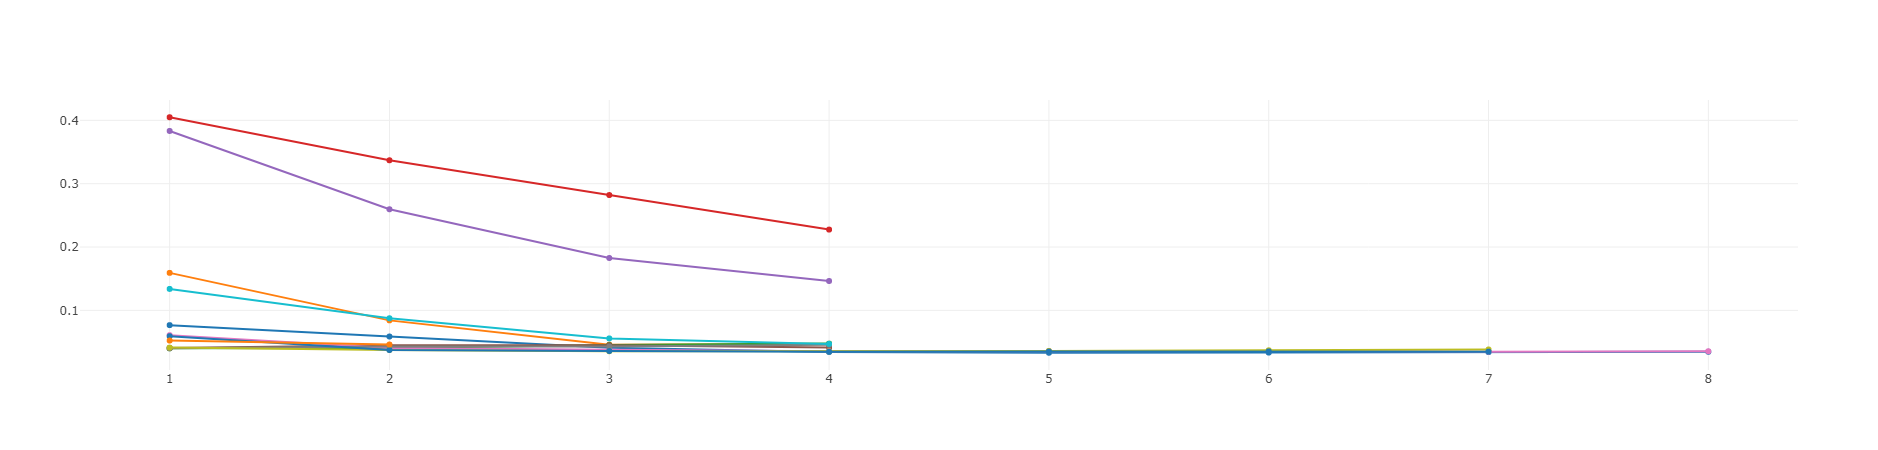

In [128]:
plot_intermediate_values(study)

In [129]:
1-study.best_value

0.9653204912887381

In [130]:
print('Number of finished trials: ', len(study.trials))

print('Best trial:')
trial = study.best_trial

print('  Value: ', trial.value)

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

print('  User attrs:')
for key, value in trial.user_attrs.items():
    print('    {}: {}'.format(key, value))

Number of finished trials:  12
Best trial:
  Value:  0.03467950871126191
  Params: 
    percentile: 61
    n_layers: 1
    n_units: 7.553650060680703
    optimizer: MomentumSGD
    momentum_sgd_lr: 0.015751320499779727
    weight_decay: 1.2363188277052218e-09
  User attrs:
    main/loss: 0.0448075495660305
    main/accuracy: 0.9903038740158081
    validation/main/loss: 0.21200016140937805
    validation/main/accuracy: 0.9269886016845703
    train/main/roc_auc: 0.9996997368242269
    val/main/minus_roc_auc: 0.03467950871126191
    valid/main/roc_auc: 0.9653204912887381
    epoch: 8
    iteration: 2023
    elapsed_time: 81.98259669999999


In [35]:
self.space = {
        #'boosting': hp.choice('boosting', ['gbdt', 'rf', 'dart', 'goss']),
        'learning_rate': hp.loguniform('learning_rate', -7, 0),
        'num_leaves': hp.qloguniform('num_leaves', 0, 7, 1),
        'max_depth': hp.choice('max_depth', [-1, hp.qloguniform('max_depth_positive', 0, 4, 1)]),
        'min_data_in_leaf': hp.qloguniform('min_data_in_leaf', 0, 6, 1),
        'min_sum_hessian_in_leaf': hp.loguniform('min_sum_hessian_in_leaf', -16, 5),
        'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1),
        'bagging_freq': hp.choice('bagging_freq', [0, hp.qloguniform('bagging_freq_positive', 0, 4, 1)]),
        'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),

        # tune?
        'max_delta_step': hp.choice('max_delta_step', [0.0, hp.loguniform('max_delta_step_positive', -7, 4)]),
        'lambda_l1': hp.choice('lambda_l1', [0, hp.loguniform('lambda_l1_positive', -16, 2)]),
        'lambda_l2': hp.choice('lambda_l2', [0, hp.loguniform('lambda_l2_positive', -16, 2)]),
        'min_gain_to_split': hp.choice('min_gain_to_split', [0.0, hp.loguniform('min_gain_to_split_positive', -16, -1)]),

        'min_data_per_group': hp.qloguniform('min_data_per_group', 0, 6, 1),
        'max_cat_threshold': hp.quniform('max_cat_threshold', 2, 128, 1),
        'cat_l2': hp.loguniform('cat_l2', 0, 3),
        'cat_smooth': hp.loguniform('cat_smooth', 0, 3),
        'max_cat_to_onehot': hp.qloguniform('max_cat_to_onehot', 0, 5, 1),
    }

    self.default_params = {
        'learning_rate': 0.1,
        'num_leaves': 127,
        'max_depth': -1,
        'feature_fraction': 1.0,
        'bagging_fraction': 1.0,
        'min_data_in_leaf': 100,
        'min_sum_hessian_in_leaf': 10,
        'lambda_l1': 0,
        'lambda_l2': 0,
        'min_data_per_group': 100,
        'max_cat_threshold': 32,
        'max_cat_to_onehot': 4
    }
    self.default_params = self.preprocess_params(self.default_params)
    self.title = 'LightGBM'


def preprocess_params(self, params):
    params_ = params.copy()
    if self.learning_task == 'classification':
        params_.update({'objective': 'binary', 'metric': 'binary_logloss',
                        'bagging_freq': 1, 'verbose': -1})
    elif self.learning_task == "regression":
        params_.update({'objective': 'mean_squared_error', 'metric': 'l2',
                        'bagging_freq': 1, 'verbose': -1})
    params_['num_leaves'] = max(int(params_['num_leaves']), 2)

    for param in [
        'max_depth',
        'min_data_in_leaf',
        'min_data_per_group',
        'max_cat_threshold',
        'max_cat_to_onehot'
    ]:
        params_[param] = int(params_[param])
    return params_

IndentationError: unexpected indent (<ipython-input-35-e57e1f58c668>, line 25)